In [2]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt


import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import statsmodels.formula.api as smf

import SessionTools.two_photon as st2p
import NeuromodPlasticity as nmp

plt.rcParams['pdf.fonttype']=42

%load_ext autoreload
%autoreload 2 


%matplotlib inline

In [3]:
basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/EPG_jGCaMP7f_OctB1RRNAi')
sess_df = pd.read_csv(basedir / 'sessions.csv')
print(sess_df.columns)
fly_id = []
for _, row in sess_df.iterrows():
    if row['rnai']==0:
        fly_id.append(row['date']+'_'+row['fly'] +'_control')
    else:
        fly_id.append(row['date']+'_'+row['fly'] +'_rnai')
sess_df['fly_id']=fly_id

figfolder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/EPG_jGCaMP7f_OctB1RRNAi')
figfolder.mkdir(parents=True, exist_ok=True)


sess_df = sess_df.loc[sess_df['usable']==1]

Index(['date', 'fly', 'session', 'closed_loop', 'rnai', 'usable',
       'fictrac_dat_file', 'notes'],
      dtype='object')


In [4]:
def load_row(row):
    if row['rnai']==0:
        outdir = pathlib.PurePath( basedir / 'control' / row['date'] / row['fly'] / row['session'] / 'preprocess.pkl')    
    elif row['rnai']==1:
        outdir = pathlib.PurePath( basedir / 'rnai' / row['date'] / row['fly'] / row['session'] / 'preprocess.pkl')
    return st2p.preprocessing.EBImagingSession.from_file(outdir)

In [5]:
stats_df = {'fly_id': [],
           'cl': [],
           'rnai': [],
           'offset_var':[],
           'offset_mean': [],
           'offset_mag': []}


for _,row in sess_df.iterrows():
    ts = nmp.session.GetTS(load_row(row))
    

    stats_df['fly_id'].append(row['fly_id'])
    stats_df['cl'].append(row['closed_loop'])
    
    if 'rnai' in row['fly_id']:
        stats_df['rnai'].append('rnai')
    else:
        stats_df['rnai'].append('control')


    stats_df['offset_var'].append(sp.stats.circvar(ts.offset))
    offset_c = ts.offset_c.mean()
    stats_df['offset_mean'].append(np.angle(offset_c))
    stats_df['offset_mag'].append(np.absolute(offset_c))
    
stats_df = pd.DataFrame.from_dict(stats_df)

In [6]:
#reduce to one entry per condition per fly by averaging
stats_df_unique = {'fly_id': [],
                   'cl': [],
                   'rnai': [],
                   'offset_var':[],
                   'offset_var_logit':[],
                   'offset_mean':[],
                   'offset_mag':[],
                   }

fly_ids = stats_df['fly_id'].unique()
for r, fly in enumerate(fly_ids):
    
    cl_mask = (stats_df['fly_id']==fly)*(stats_df['cl']>=1) # closed_loop ==1 is the very first experience in closed loop
                                                           # closed_loop >1 takes data where fly has at least 10 min of 
                                                           # experience prior to imaging
    dark_mask = (stats_df['fly_id']==fly)*(stats_df['cl']==0) 
    if (cl_mask.sum()>0) and (dark_mask.sum()>0): # take only flies with both closed loop and dark data
        
        rnai = stats_df['rnai'].loc[cl_mask]
        
        cl = stats_df['offset_var'].loc[cl_mask].mean() #average across sessions
        cl_mu = sp.stats.circmean(stats_df['offset_mean'].loc[cl_mask])

        stats_df_unique['fly_id'].append(fly)
        stats_df_unique['cl'].append(1)
        stats_df_unique['rnai'].append(rnai.iloc[0])
        stats_df_unique['offset_var'].append(cl)
        stats_df_unique['offset_var_logit'].append(sp.special.logit(cl)) # logit transform for mixed effects model below
        stats_df_unique['offset_mean'].append(cl_mu)
        stats_df_unique['offset_mag'].append(stats_df['offset_mag'].loc[cl_mask].mean())
    
        dark = stats_df['offset_var'].loc[dark_mask].mean() # average across flies
        dark_mu = sp.stats.circmean(stats_df['offset_mean'].loc[dark_mask])
        
        stats_df_unique['fly_id'].append(fly)
        stats_df_unique['cl'].append(0)
        stats_df_unique['rnai'].append(rnai.iloc[0])
        stats_df_unique['offset_var'].append(dark)
        stats_df_unique['offset_var_logit'].append(sp.special.logit(dark)) # logit tranform for mixed effect model below
        stats_df_unique['offset_mean'].append(dark_mu)
        stats_df_unique['offset_mag'].append(stats_df['offset_mag'].loc[dark_mask].mean())
        
stats_df_unique = pd.DataFrame.from_dict(stats_df_unique)

In [7]:
# reformat for plotting only
stats_df_plot = {'fly_id': [],
                 'rnai': [],
                 'offset_var_dark':[],
                 'offset_var_closed_loop':[],
                 'offset_mag_dark': [],
                 'offset_mag_closed_loop': [],
                }
fly_ids = stats_df_unique['fly_id'].unique()
for fly in fly_ids:
    stats_df_plot['fly_id'].append(fly)
    
    fly_mask = stats_df_unique['fly_id']==fly
    
    _df = stats_df_unique.loc[fly_mask]
    stats_df_plot['rnai'].append(_df['rnai'].iloc[0])
    
    _df_d = _df.loc[_df['cl']==0]
    stats_df_plot['offset_var_dark'].append(_df_d['offset_var'])
    stats_df_plot['offset_mag_dark'].append(_df_d['offset_mag'])
    
    _df_cl = _df.loc[_df['cl']==1]
    stats_df_plot['offset_var_closed_loop'].append(_df_cl['offset_var'])
    stats_df_plot['offset_mag_closed_loop'].append(_df_cl['offset_mag'])
stats_df_plot = pd.DataFrame.from_dict(stats_df_plot)

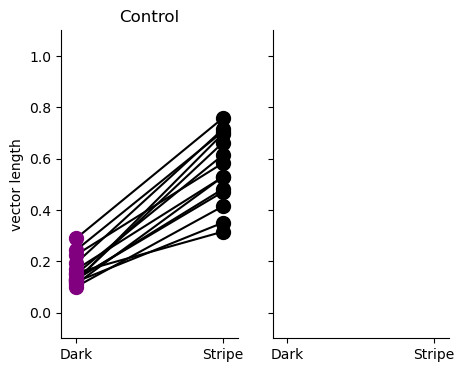

In [10]:
fig,ax = plt.subplots(1,2,sharey=True, figsize=[5,4])

c_df = stats_df_plot.loc[stats_df_plot['rnai']=='control']
ax[0].set_title('Control')
# ax[0].plot([0,1], c_df[['offset_var_dark', 'offset_var_closed_loop']].T, color='black', zorder=-10)
ax[0].plot([0,1], c_df[['offset_mag_dark', 'offset_mag_closed_loop']].T, color='black', zorder=-10)
# ax[0].scatter(np.zeros((c_df.shape[0],)), c_df['offset_var_dark'], color='purple', alpha=1, s=100)
ax[0].scatter(np.zeros((c_df.shape[0],)), c_df['offset_mag_dark'], color='purple', alpha=1, s=100)
# ax[0].scatter(np.ones((c_df.shape[0],)), c_df['offset_var_closed_loop'], color='black', alpha=1, s=100)
ax[0].scatter(np.ones((c_df.shape[0],)), c_df['offset_mag_closed_loop'], color='black', alpha=1, s=100)

# rnai_df = stats_df_plot.loc[stats_df_plot['rnai']=='rnai']
# ax[1].set_title('RNAi')
# ax[1].plot([0,1], rnai_df[['offset_var_dark', 'offset_var_closed_loop']].T, color='black')
# ax[1].scatter(np.zeros((rnai_df.shape[0],)), rnai_df['offset_var_dark'], color='purple', alpha=.4, s=100)
# ax[1].scatter(np.ones((rnai_df.shape[0],)), rnai_df['offset_var_closed_loop'], color='black', alpha=.4, s=100)



for _ax in ax:
    _ax.set_ylim([-.1,1.1])
    _ax.set_xlim([-.1,1.1])
    _ax.set_yticks([0,.2,.4,.6,.8,1.])

    _ax.set_xticks([0, 1], labels=['Dark', 'Stripe'])
    _ax.spines['top'].set_visible(False)
    _ax.spines['right'].set_visible(False)
    
# ax[0].set_ylabel('Offset variance')
ax[0].set_ylabel('vector length')


fig.savefig(figfolder / 'offset_mag_summary.pdf', format='pdf')

difference from chance: t=0.0,p=0.000978706525317055
(14,) (14,)
difference from fwhm: t=2.0,p=0.0015191855658097234


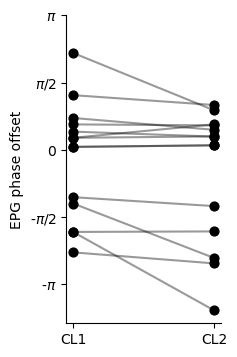

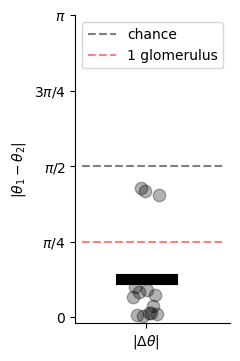

In [9]:
fig, ax = plt.subplots(figsize=[2,4])

ctrl_fly_ids = [f for f in fly_ids if "control" in f]

offsets = []
fwhm = []
for r, fly in enumerate(ctrl_fly_ids):
    
    fly_df = sess_df.loc[sess_df['fly_id']==fly]
    if np.sort(fly_df['closed_loop'].to_numpy()).tolist() == [0,1,2]: # all sessions exist
        offset_dict={}
        fwhm_dict={}
        for _, row in fly_df.iterrows():
            ts = nmp.session.GetTS(load_row(row))
            offset_dict[row['closed_loop']]= np.angle(ts.offset_c.mean())
            fwhm_dict[row['closed_loop']]=  ts.fwhm
            # offset_dict[row['closed_loop']]= np.angle(nmp.session.GetTS(load_row(row)).offset_c.mean())
    else:
        pass
    
    offset1 = offset_dict[1]
    offset2 = offset_dict[2]
    offset2 = np.array([offset2+2*np.pi, offset2, offset2-2*np.pi])
    offset2 = offset2[np.argmin(np.abs(offset2-offset1))]
    ax.plot([0,1], [offset1, offset2], color='black', alpha=.4)
    ax.scatter([0,1], [offset1, offset2], c='black', s=40)
    offsets.append([offset_dict[1], offset_dict[2]])
    fwhm.append([fwhm_dict[1], fwhm_dict[2]])
    
_ = ax.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], labels=[r"-$\pi$", r"-$\pi$/2", 0, r"$\pi$/2", r"$\pi$"])
ax.set_xticks([0,1], labels=['CL1', 'CL2'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('EPG phase offset')
fig.savefig(figfolder / 'offset1_v_offset2_scatter.pdf')

fig, ax = plt.subplots(figsize=[2,4])

offsets = np.array(offsets)
offset_diff = np.ravel(np.abs(np.diff(offsets,axis=-1)) % np.pi)
fwhm = np.array(fwhm)

ax.scatter(np.linspace(0,.1,num=offsets.shape[0]), offset_diff, color='black', alpha=.3, s=80)
# ax.scatter(np.linspace(0,.1,num=offsets.shape[0])+1, fwhm.mean(axis=-1), color='red', alpha=.3, s=80)
# for i, x in enumerate(np.linspace(0,.1,num=offsets.shape[0])):
#     ax.plot([x,x+1], [offset_diff[i], fwhm[i,:].mean()], color='black', alpha=.3)

# ax.scatter(np.linspace(0,.1,num=offsets.shape[0])+1, fwhm.mean(axis=-1), color='black', alpha=.3, s=80)
ax.plot([-.05,.15],offset_diff.mean()*np.ones([2,]), color='black', linewidth=8)
ax.plot([-.2,.35], [np.pi/2, np.pi/2], 'k--', alpha=.5, zorder=-1, label='chance')
ax.plot([-.2, .35], np.pi/4*np.ones((2,)), 'r--', alpha=.5, zorder=-1, label='1 glomerulus')
# ax.plot([-.2,.35], np.median(fwhm.mean(axis=-1))*np.ones([2,]), 'r--', alpha=.5, zorder=-1)
ax.legend()

_ = ax.set_yticks([0,np.pi/4,np.pi/2,3*np.pi/4, np.pi], labels=[0, r"$\pi$/4", r"$\pi$/2", r"$3\pi$/4", r"$\pi$"])
# ax.set_xticks([.05, 1.05], labels=[r'$| \Delta \theta |$', 'bump fwhm'])
ax.set_xticks([.05], labels=[r'$| \Delta \theta |$'])
ax.set_ylabel(r'$| \theta_{1} - \theta_2 |$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(figfolder / 'offset_diff.pdf')


t,p = sp.stats.wilcoxon(offset_diff-np.pi/2)
print(f"difference from chance: t={t},p={p}")

print(fwhm.mean(axis=-1).shape, offset_diff.shape)
t, p = sp.stats.wilcoxon(offset_diff-fwhm.mean(axis=-1))
print(f"difference from fwhm: t={t},p={p}")



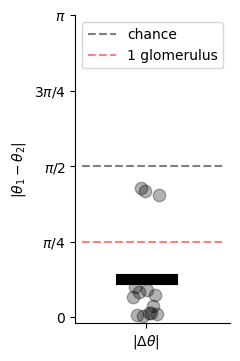

In [9]:
fig, ax = plt.subplots(figsize=[2,4])


ax.scatter(np.linspace(0,.1,num=offsets.shape[0]), offset_diff, color='black', alpha=.3, s=80)
ax.plot([-.05,.15],offset_diff.mean()*np.ones([2,]), color='black', linewidth=8)
ax.plot([-.2,.35], [np.pi/2, np.pi/2], 'k--', alpha=.5, zorder=-1, label='chance')
ax.plot([-.2, .35], np.pi/4*np.ones((2,)), 'r--', alpha=.5, zorder=-1, label='1 glomerulus')
ax.legend()

_ = ax.set_yticks([0,np.pi/4,np.pi/2,3*np.pi/4, np.pi], labels=[0, r"$\pi$/4", r"$\pi$/2", r"$3\pi$/4", r"$\pi$"])
# ax.set_xticks([.05, 1.05], labels=[r'$| \Delta \theta |$', 'bump fwhm'])
ax.set_xticks([.05], labels=[r'$| \Delta \theta |$'])
ax.set_ylabel(r'$| \theta_{1} - \theta_2 |$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

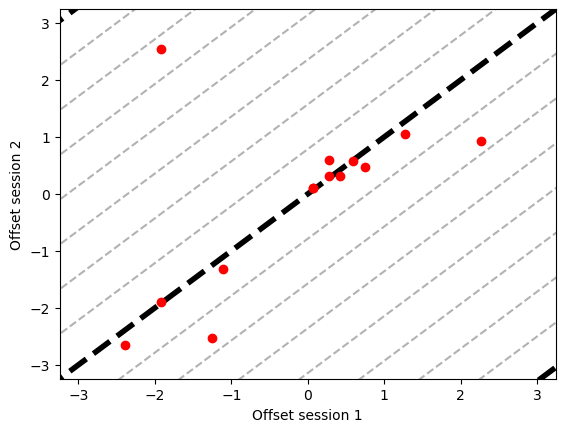

In [10]:
fig, ax = plt.subplots()
ax.scatter(offsets[:,0], offsets[:,1], color='red')

x = np.linspace(-6,6)
ax.plot(x,x, 'k--',linewidth=4, zorder=-10)
ax.plot(x,x-2*np.pi, 'k--', linewidth=4, zorder=-10)
ax.plot(x,x+2*np.pi, 'k--', linewidth=4, zorder=-10)
for dx in np.arange(np.pi/4, 2*np.pi, np.pi/4):
    ax.plot(x, x-dx, 'k--', alpha=.3)
    ax.plot(x, x+dx, 'k--', alpha=.3)

    
ax.set_xlabel('Offset session 1')
ax.set_ylabel('Offset session 2')


ax.set_xlim([-np.pi-.1, np.pi+.1])
ax.set_ylim([-np.pi-.1, np.pi+.1])
fig.savefig(figfolder / 'offset1_v_offset2.pdf')





In [11]:


for fly in ctrl_fly_ids[:1]:
    cl1 = sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['closed_loop']==1)]
    dark = sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['closed_loop']==0)]
    cl2 = sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['closed_loop']==2)]
    
    if cl1.shape[0]>0 and dark.shape[0]>0 and cl2.shape[0]>0:
        
        cl1_ts =  nmp.session.GetTS(load_row(cl1.iloc[0]))
        print(cl1_ts.fwhm)

1.1780972450961724


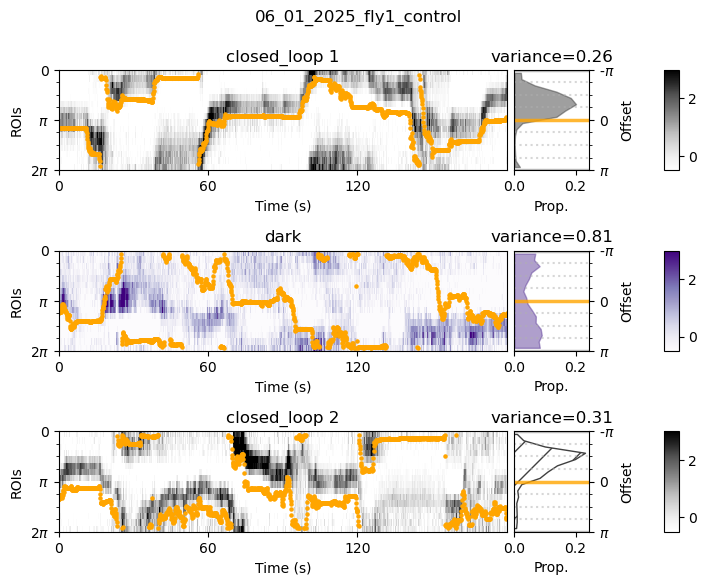

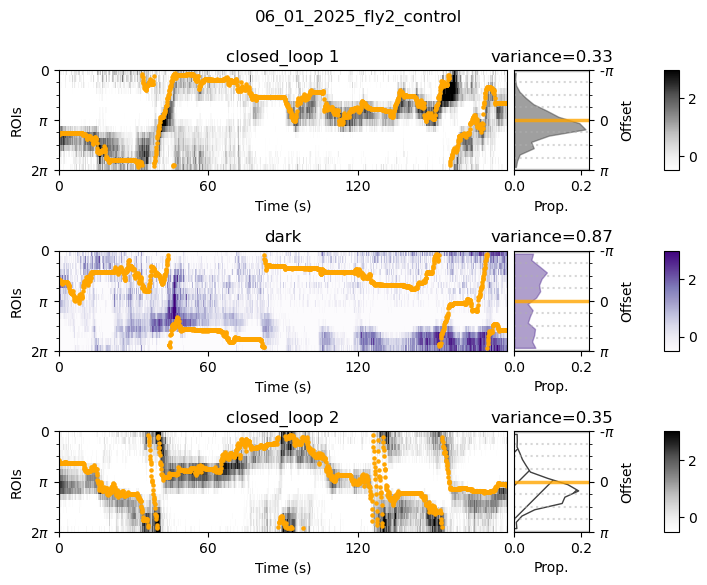

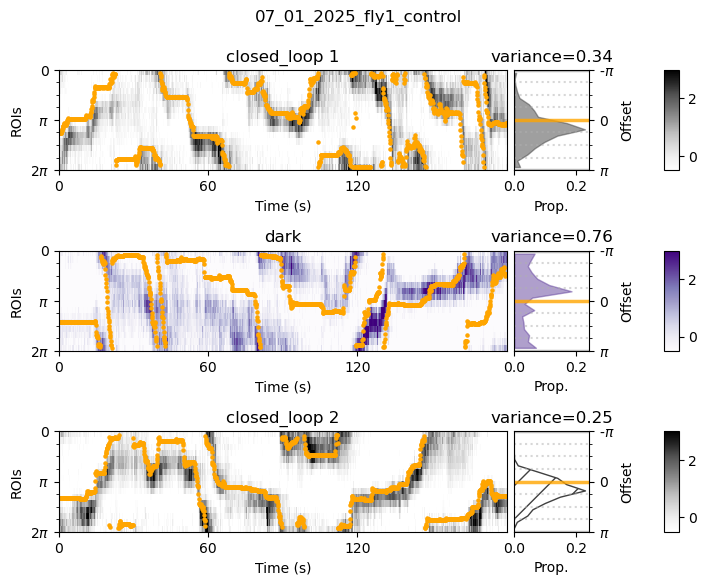

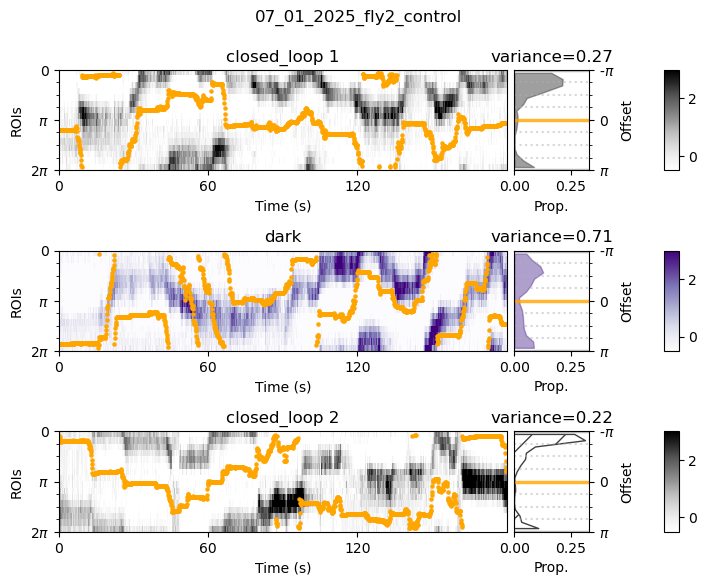

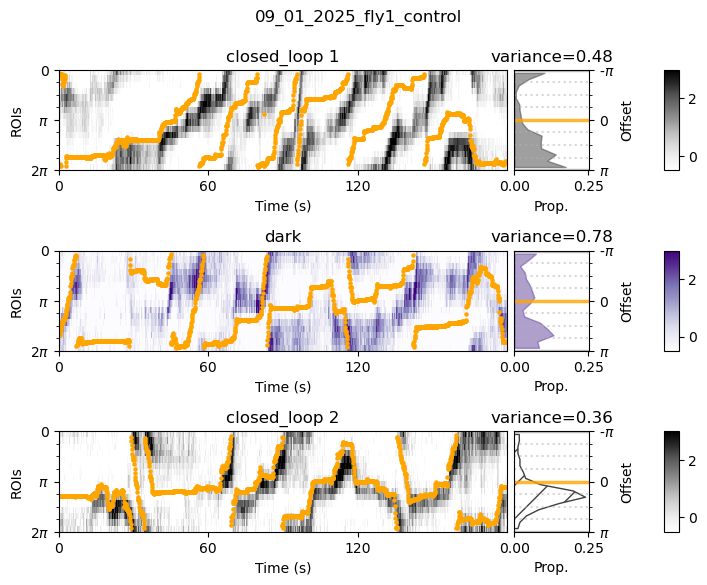

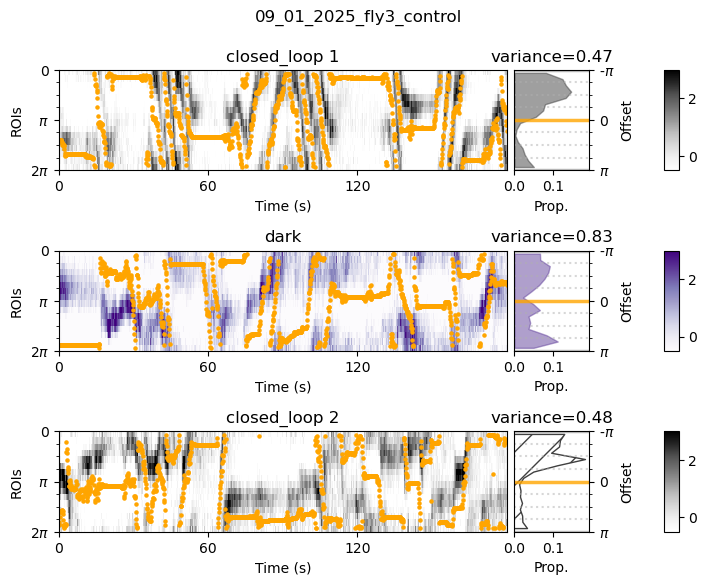

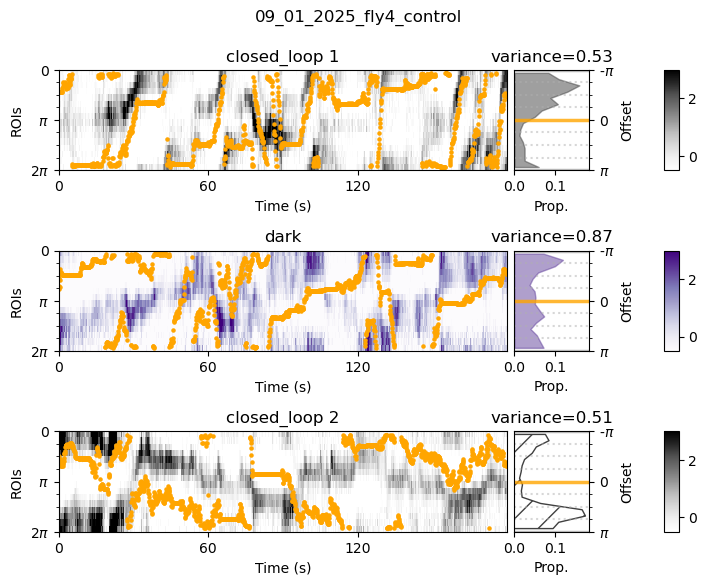

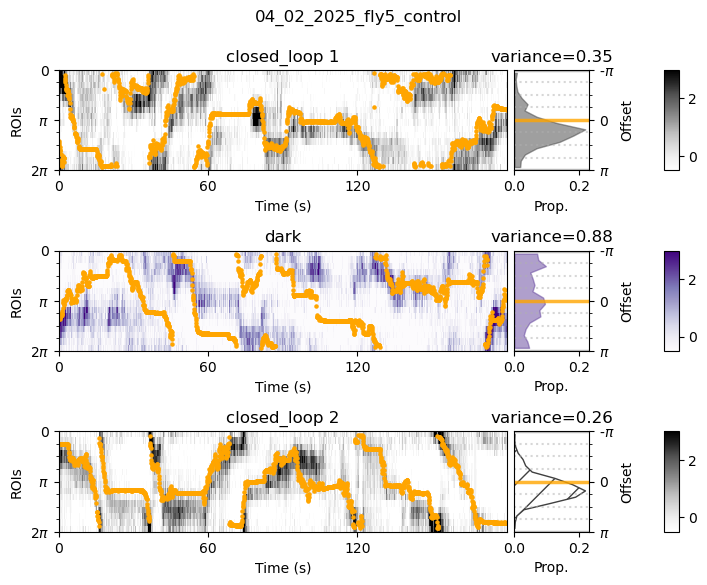

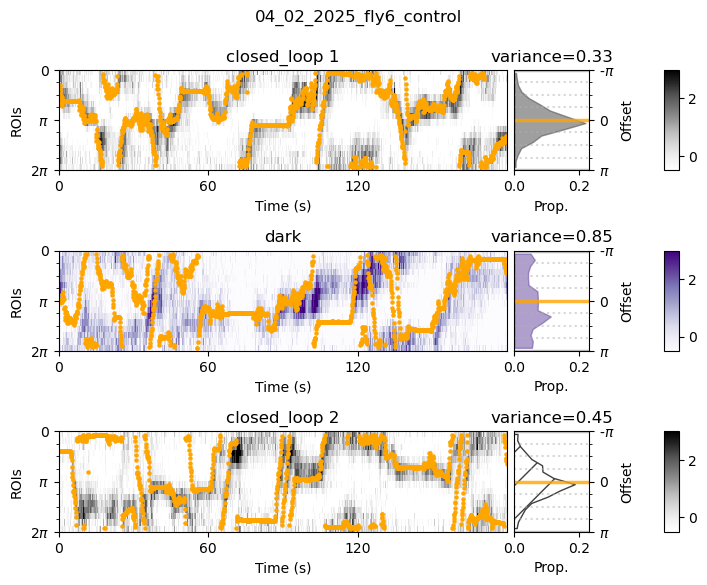

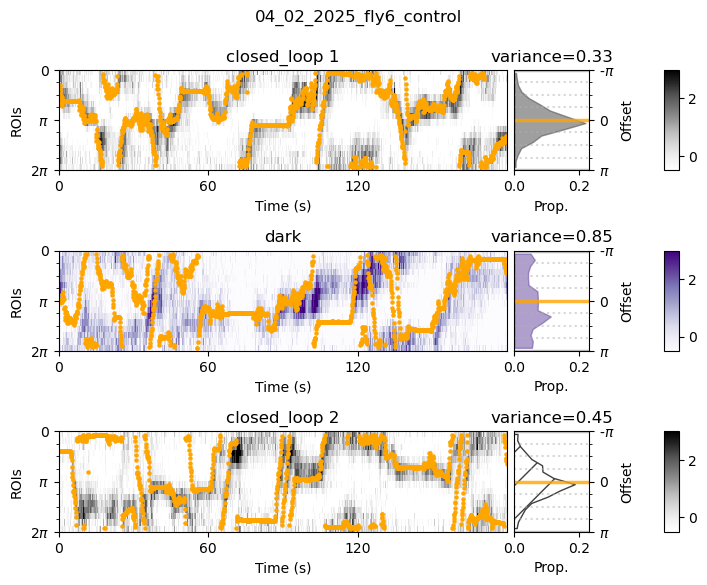

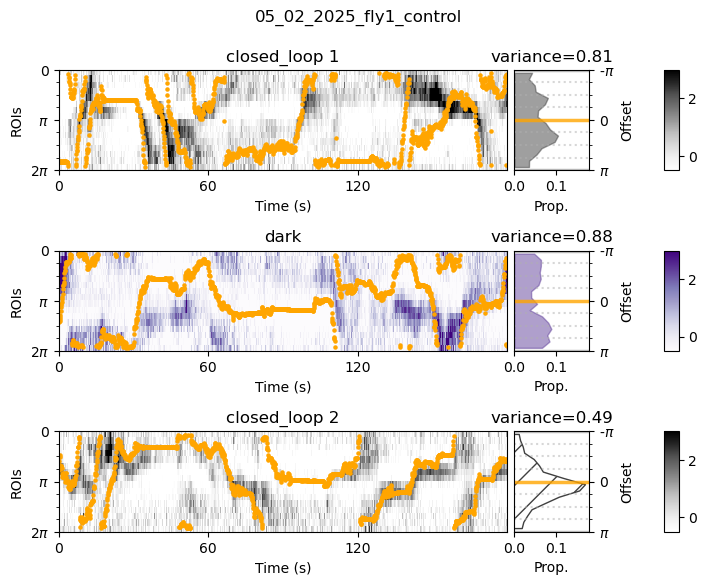

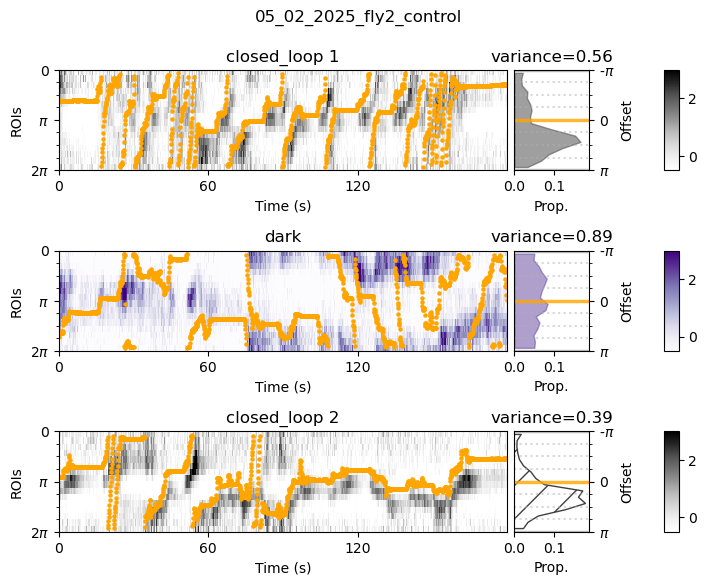

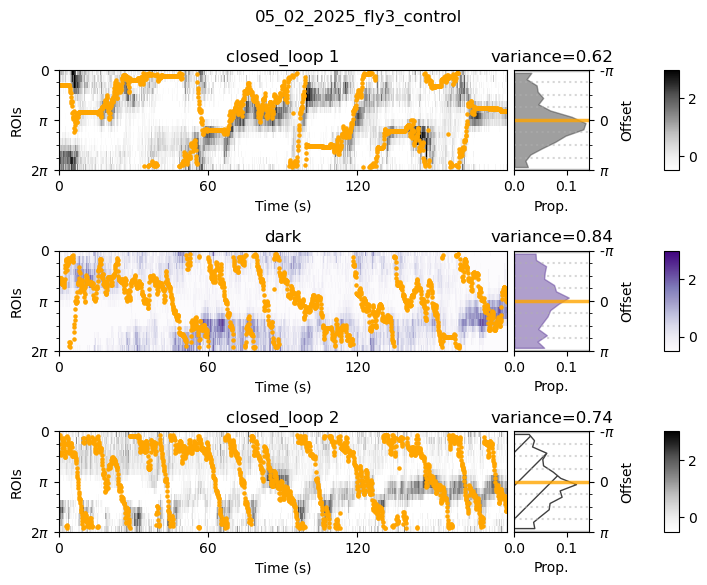

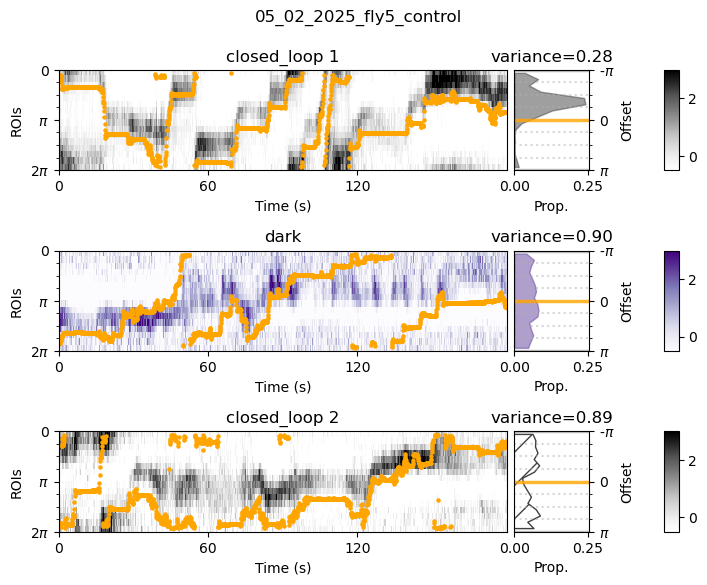

In [ ]:

session_folder = figfolder / "sessions"
session_folder.mkdir(parents=True, exist_ok=True)

for fly in ctrl_fly_ids:
    # fly = ctrl_fly_ids[0]
    cl1 = sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['closed_loop']==1)]
    dark = sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['closed_loop']==0)]
    cl2 = sess_df.loc[(sess_df['fly_id']==fly) & (sess_df['closed_loop']==2)]

    if cl1.shape[0]>0 and dark.shape[0]>0 and cl2.shape[0]>0:
        
        ts_dict = {'fly': fly,
                    'closed_loop 1': nmp.session.GetTS(load_row(cl1.iloc[0])),
                    'dark': nmp.session.GetTS(load_row(dark.iloc[0])),
                    'closed_loop 2': nmp.session.GetTS(load_row(cl2.iloc[0])),
                    }
        
    else:
        pass


    fig, axtup = nmp.epg_across_dark.plot_sess_heatmaps_w_hist(ts_dict, vmax=2.5, twindow=(0,180.1))
    fly_folder = session_folder / fly
    fly_folder.mkdir(parents=True, exist_ok=True)
    
    fig.savefig(fly_folder / "heatmaps.pdf")
